## Exploring Simulation Scenarios

This notebook provides a framework for exploring the capabilities of our anesthesia simulator through two distinct types of scenarios:

1.  **Disturbance Scenario:** This deterministic scenario evaluates the system's response to a consistent profile of stimuli. It simulates a standard patient undergoing surgery who experiences continuous stimulation at the highest intensity that the user allows. By maintaining a deterministic disturbance profile across simulations, this scenario serves as a controlled environment for the rigorous validation and design of decision-making systems and closed-loop control algorithms in the presence of a substantial and predictable disturbance.

2.  **Closed-Loop Control Scenario:** This section provides an example to show the users how to implement and test their own closed-loop control strategies for anesthesia administration. This enables the evaluation of different control algorithms' efficacy and robustness in maintaining desired anesthetic levels.

**Initial Setup**

In this section, we import the necessary external libraries commonly used in scientific computing and data analysis, such as NumPy for numerical operations and Matplotlib for visualization. We also import the specific local libraries from our custom Python package that provide access to the anesthesia simulator's functionalities and models.

In [ ]:
# External libraries import
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
# Make sure you are in Python directory
# Local libraries import
from AReS import Simulator, Model, Interaction, DoHMeasure, DisturbanceType

## 1. Disturbance Scenario: Maximum Stimulation for Decision-Making System Validation

This scenario simulates a healthy patient undergoing surgery with a continuous, maximum-intensity surgical stimulation. Importantly, this scenario is deterministic, meaning the disturbance profile remains consistent across multiple simulations. This deliberate design choice allows users to utilize this specific scenario as a predefined and reproducible testbed for the rigorous validation and design of their decision-making systems under consistent, high-level process disturbance. By keeping the disturbance profile constant, researchers can reliably assess the performance and robustness of their automated control strategies in the presence of a significant and predictable challenge.

**Disturbance Setup**

The `stimuli` dictionary defines a sequence of simulated surgical events or disturbances that will occur during the anesthesia procedure. The keys of the dictionary represent the start time of each disturbance in seconds from the beginning of the simulation. The value associated with each start time is a tuple containing the following information:

* **Disturbance Type:** The type of surgical event or disturbance being simulated (e.g., intubation, incision, skin manipulation, and suture).
* **Duration:** The duration of the disturbance in seconds.
* **Maximum Intensity:** A list of three numerical values representing the maximum intensity of the disturbance's effect on three key physiological variables:
    * The first element corresponds to the maximum intensity affecting the Depth of Hypnosis (DoH).
    * The second element corresponds to the maximum intensity affecting the Heart Rate (HR).
    * The third element corresponds to the maximum intensity affecting the Mean Arterial Pressure (MAP).

Here's a breakdown of the specific disturbances defined in the `stimuli` dictionary:

* At **1 minute (60 seconds)**, an **INTUBATION** disturbance will begin and last for **2 minutes (120 seconds)**. The maximum intensity of this disturbance is `[10, 10, 20]` for DoH, HR, and MAP, respectively.
* At **5 minutes (300 seconds)**, an **INCISION** disturbance will begin and last for **2 minutes (120 seconds)**. The maximum intensity is `[10, 10, 20]` for DoH, HR, and MAP.
* At **10 minutes (600 seconds)**, a **SKIN_MANIPULATION** disturbance will begin and last for **10 minutes (600 seconds)**. The maximum intensity is `[5, 5, 10]` for DoH, HR, and MAP.
* At **21 minutes (1260 seconds)**, a **SUTURE** disturbance will begin and last for **5 minutes (300 seconds)**. The maximum intensity is `[2, 2, 4]` for DoH, HR, and MAP.

In [52]:
stimuli = {
    1 * 60: (DisturbanceType.INTUBATION, 2 * 60, [10, 10, 20]), 
    5 * 60: (DisturbanceType.INCISION, 2 * 60, [10, 10, 20]),  
    10 * 60: (DisturbanceType.SKIN_MANIPULATION, 10 * 60, [5, 5,10]),
    21 * 60: (DisturbanceType.SUTURE, 5 * 60, [2, 2, 4]) 
}

**Simulation Setup:**
The following code cell initializes the anesthesia simulator with specific configurations for the simulation run. Let's break down each parameter:

* **`simulator = Simulator.create()`**: This line creates an instance of the `Simulator` object. This is the core object that will manage the simulation environment, including patient models, drug models, and the progression of time.

* **`interaction = Interaction.SURFACE`**: This parameter defines how the interaction between the two anesthetic drugs, propofol ('prop') and remifentanil ('remi'), will be modeled. Here, `Interaction.SURFACE` indicates that a surface model will be implemented.

* **`doh_measure = DoHMeasure.BOTH`**: This parameter specifies which physiological signal will be used as the measure of the Depth of Hypnosis (DoH). In this case, `DoHMeasure.BOTH` indicates that the simulator will track and report both the BIS and WAV signals.

* **`t_sim = 30 * 60`**: This parameter sets the total duration of the simulation. The value is given in seconds, so `30 * 60` equates to a simulation lasting for 30 minutes.

* **`t_s = 5`**: This parameter defines the sampling interval for the simulation and potential control actions. A value of `5` indicates that the simulator will update its state and potentially apply control inputs every 5 seconds. This parameter is crucial for discrete-time control system implementations.

* **`pk_models = {'prop': Model.ELEVELD, 'remi': Model.ELEVELD}`**: This dictionary specifies the pharmacokinetic (PK) models to be used for propofol and remifentanil. Note that only one choice of pk model exists for other two drugs (norepinephrine and rocuronium). Here, the `Model.ELEVELD` model is selected for both propofol ('prop') and remifentanil ('remi').

* **`pd_models = {'prop': Model.PATIENT_SPECIFIC, 'remi': Model.ELEVELD}`**: This dictionary specifies the pharmacodynamic (PD) models to be used for each drug. These PD models describe the relationship between the drug concentration at the effect site and the changes in DoH. Here, a `Model.PATIENT_SPECIFIC` PD model will be used for propofol and for remifentanil, the population-based `Model.ELEVELD` PD model will be used.

In [4]:
simulator = Simulator.create()
interaction = Interaction.SURFACE
doh_measure = DoHMeasure.BOTH
t_sim = 30 * 60
t_s = 5
pk_models = {'prop': Model.ELEVELD, 'remi': Model.ELEVELD}
pd_models = {'prop': Model.PATIENT_SPECIFIC, 'remi': Model.ELEVELD}

Next, we define the infusion rates for the four drugs considered in this simulation: propofol, remifentanil, norepinephrine, and rocuronium. In this specific implementation, the infusion rate for each drug remains constant throughout the entire simulation. However, users have the flexibility to define time-varying infusion profiles for any or all of these drugs according to their experimental needs.

In [5]:
u_prop = [0.2] * t_sim
u_remi = [0.2] * t_sim
u_nore = [0.01] * t_sim
u_rocu = [0.1] * t_sim

In [30]:
patient_id = 2
simulator.init_simulation_from_file(id_patient=patient_id, t_sim=t_sim, t_s=t_s, pk_models=pk_models,
                                        pd_models=pd_models, interaction=interaction, doh_measure=doh_measure,worst_case=True,stimuli=stimuli)
simulator.run_complete_simulation(u_prop, u_remi, u_nore, u_rocu)
simulator.save_simulation()

results = simulator.get_patient_results()

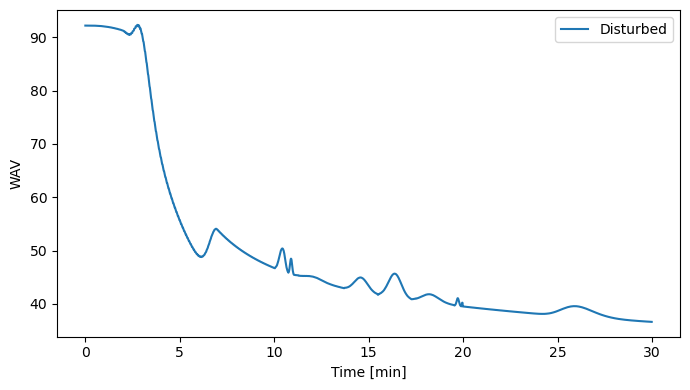

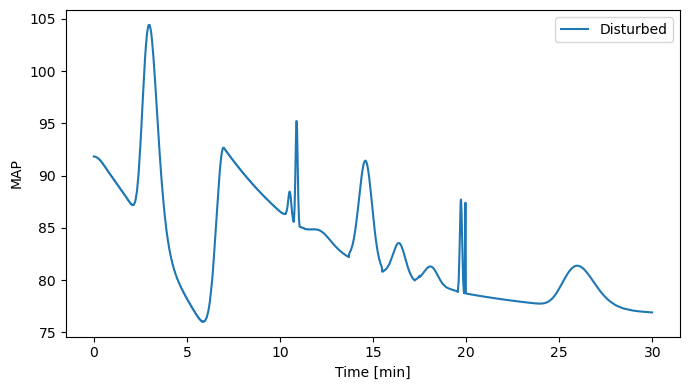

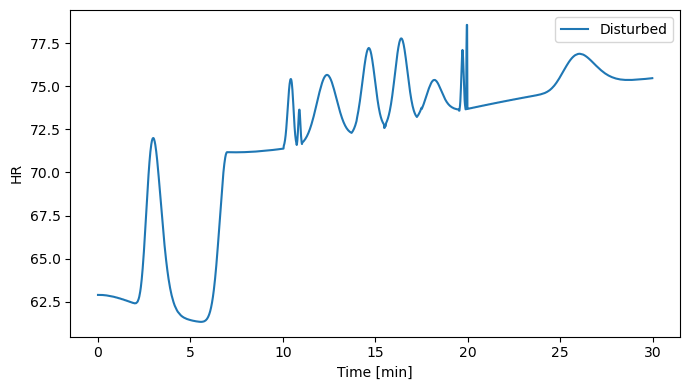

In [31]:
num_samples = len(results['_BIS_all'][0])
t = np.arange(num_samples) / 60
names = {'_WAV_all': 'WAV', '_MAP_all': 'MAP', '_HR_all': 'HR'}


for key in names.keys():
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(t,results[key][0], label='Disturbed')
    ax.set_xlabel('Time [min]')
    ax.set_ylabel(names[key])
    ax.legend()
    plt.tight_layout()
    plt.show()

## Closed-Loop Control Scenario

Here, we demonstrate a step-wise simulation with the disturbance profile defined in the previous section, and show how the user can incorporate a closed-loop control policy. First, we define a class of PID controller, then simulates a closed-loop control scenario for propofol administration using the AReS simulator.

### PIDController Class

This Python class implements a standard **Proportional-Integral-Derivative (PID) control algorithm**. It's designed to calculate a control signal (the "action") based on the difference between a desired reference point and the current state of a system.

**Key Components:**

* **`__init__(self, Kp, Ki, Kd, reference)`**:
    * Initializes the controller with the **proportional gain (`Kp`)**, **integral gain (`Ki`)**, and **derivative gain (`Kd`)**.
    * Sets the target or **`reference`** value that the controller aims to achieve.
    * Initializes internal state variables to keep track of the error (`error_state`) and the accumulated error over time (`integral_error_state`).

* **`compute_action(self, patient_state, t_s)`**:
    * This is the core method called at each time step to calculate the control output.
    * It first determines the **`error`** as the difference between the current `patient_state` and the `reference`.
    * Calculates the three components of the PID output:
        * **Proportional Term (P)**: Proportional to the current `error`.
        * **Integral Term (I)**: Proportional to the accumulation of past errors (`integral_error_state`), helping to eliminate steady-state errors.
        * **Derivative Term (D)**: Proportional to the rate of change of the error, helping to dampen oscillations and predict future error.
    * The total **`action`** is the sum of the P, I, and D terms.
    * The calculated `action` is then **clipped** to a specified range (0 to 2 in this code).
    * Finally, it updates the `error_state` to the current `error` for use in the next time step's derivative calculation.

In essence, this class provides a closed-loop control mechanism that continuously adjusts its output (`action`) to minimize the error between the system's current state and the desired reference point.

In [43]:
class PIDController:
    def __init__(self, Kp, Ki, Kd, reference):
        self.Kp = Kp   # Proportional gain
        self.Ki = Ki   # Integral gain
        self.Kd = Kd   # Derivative gain
        self.reference = reference
        self.error_state = 0           # Stores the error from the previous time step for derivative calculation
        self.integral_error_state = 0  # Accumulates the error over time for integral calculation

    def compute_action(self, patient_state, t_s):
            # Calculate error
            # Note that the gain from propofol to DoH is negative for the process system
            error = patient_state - self.reference
        
            # Proportional term
            P_out = self.Kp * error
            
            # Integral term
            self.integral_error_state += error * t_s
            I_out = self.Ki * self.integral_error_state
            
            # Derivative term
            derivative = (error - self.error_state) / t_s
            D_out = self.Kd * derivative
            
            # Compute total output
            action = P_out + I_out + D_out
            action = np.clip(action, 0, 2)
            # print(action)
            
            # Update the state of the error
            self.error_state = error
            
            return action


This code snippet demonstrates how to run a simulation using a `simulator` object and control a specific patient state ('WAV', likely representing Depth of Hypnosis or a similar metric) using the previously defined `PIDController`.
1.  **Setup**:
    * Resets the `simulator`.
    * Initializes the simulation for a specific `patient_id` (`patient_id = 2`) and the setting provided in previous scenario
    * Defines the `wav_desired` as the target reference for the PID controller.
    * Instantiates the `PIDController` with specific gains (`Kp`, `Ki`, `Kd`) and the `wav_desired` reference.
    * Initializes an array (`u_prop_controlled`) to store the calculated propofol infusion rates.

2.  **Simulation Loop**:
    * The code iterates through the simulation time step by step.
    * In each step, it advances the `simulator` by one step, applying the *previous* time step's calculated propofol infusion rate as input.
    * It retrieves the updated patient `states` from the simulator, specifically focusing on the `wav_state`.
    * The `pid.compute_action()` method is called, using the current `wav_state` and the time step `t_s`, to calculate the *new* propofol infusion rate required to move towards the `wav_desired`.
    * This newly calculated rate is stored in the `u_prop_controlled` array and will be used as the input in the *next* simulation step, creating a feedback loop.

3.  **Results and Plotting**:
    * After the simulation loop finishes, the full simulation results are saved and retrieved from the `simulator`.
    * The code then extracts the recorded 'WAV' state and the applied `u_prop_controlled` values.
    * Finally, it generates plots to visualize:
        * The simulated 'WAV' state over time, showing how the PID controller affected the patient state.
        * The propofol infusion rate applied by the controller over time.

This script effectively simulates a closed-loop control system where a PID controller adjusts the propofol infusion rate to maintain the patient's 'WAV' state at the desired level.

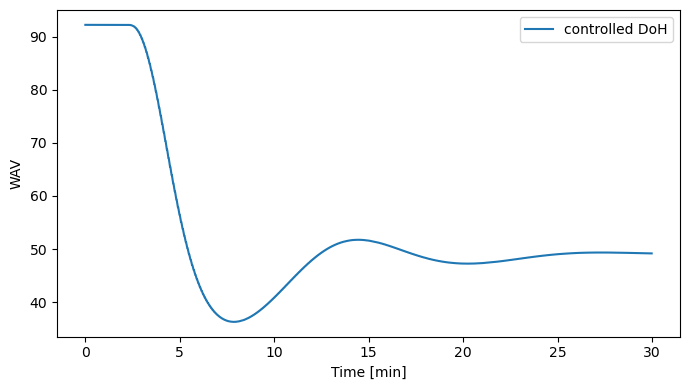

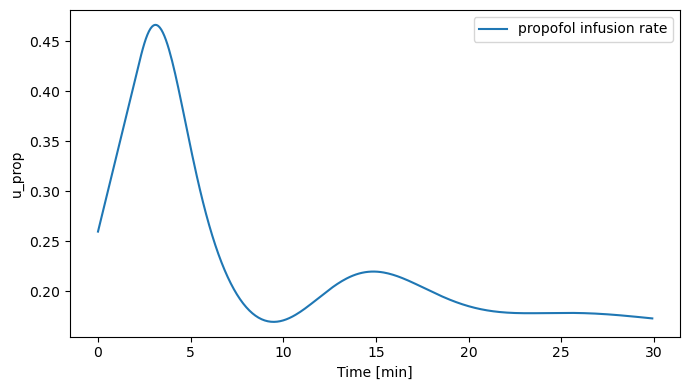

In [51]:
simulator.reset()

patient_id = 2
simulator.init_simulation_from_file(id_patient=patient_id, t_sim=t_sim, t_s=t_s, pk_models=pk_models,
                                        pd_models=pd_models, interaction=interaction, doh_measure=doh_measure,worst_case=True,stimuli=None)
wav_desired = 50  # Desired DoH
pid = PIDController(Kp=0.006, Ki=0.00003, Kd=0, reference=wav_desired)
u_prop_controlled = np.zeros(t_sim // t_s+1)
for time in range(t_sim // t_s):
    # Run one step of simulation
    simulator.one_step_simulation(u_prop_controlled[time], 0, 0, 0)
    # Report the states of the patient after one-step simulation
    states = simulator.get_patient_state()
    # The controlled output is wav index, and the PID controller calculates the propofol infusion rate based on wav index.
    wav_state = states['WAV']
    u_prop_controlled[time+1] = pid.compute_action(wav_state, t_s)
simulator.save_simulation()

results = simulator.get_patient_results()
num_samples = len(results['_WAV_all'][0])
t = np.arange(num_samples) / 60
# Choose outputs you like to plot
names = {'_WAV_all': 'WAV'}

# Plot ouputs of the simulator
for key in names.keys():
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(t,results[key][0], label='controlled DoH')
    ax.set_xlabel('Time [min]')
    ax.set_ylabel(names[key])
    ax.legend()
    plt.tight_layout()
    plt.show()

# Plot the control actions
t_input = np.arange(len(u_prop_controlled))*t_s/60
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(t_input[:-1],u_prop_controlled[1:], label='propofol infusion rate')
ax.set_xlabel('Time [min]')
ax.set_ylabel('u_prop')
ax.legend()
plt.tight_layout()
plt.show()

